# Lab Assigment 1 Q&A Candies
<p style="text-align:left;">
    José Pedro Cruz
    <span style="float:right;">
        up201504646
    </span>
</p>
<p style="text-align:left;">
    Martinho Figueiredo
    <span style="float:right;">
        up201506179
    </span>
</p>
<p style="text-align:left;">
    Nuno Nascimento
    <span style="float:right;">
        up201907933
    </span>
</p>

In [1]:
#imports and line magic to make the notebook work

%pip install --upgrade pip
%pip install opencv-python
%pip install matplotlib
%pip install sympy
%pip install pandas
%pip install ipympl



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:

%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import glob
import sympy
from sympy import * 
import pandas as pd
from scipy.spatial.distance import pdist

## Intrinsic calibration

[Rodrigues Ref](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#void%20Rodrigues(InputArray%20src,%20OutputArray%20dst,%20OutputArray%20jacobian))


[Extrinsic](https://stackoverflow.com/questions/55220229/extrinsic-matrix-computation-with-opencv)
[Size of Squares](https://stackoverflow.com/questions/37310210/camera-calibration-with-opencv-how-to-adjust-chessboard-square-size)

# Scaling
This implementation relies on scaling the object point matriz so that it represent the actual size of the printed checkboard. 

Another possible implementation, would envolve calculating the average pixel distace between the corners and divide that by the size of the squares giving us a average pixel to lenght unit ratio (this would be a lot more ??suscetipble?? to radial distortion and off focus plane objects)

In [3]:

def unwarp(img, mtx, dist):
    h,  w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    dst = cv.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image to avoid the black zones created in unwarping
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    return dst

# Parameteres:
#   img -> image BGR to calculate the camera matrices
#   outtype -> can output :
#       'num' -> Only matrices
#       'plot' -> Only images
#       'all' -> both
#       'none' -> nothing
#   unit -> can be:
#       'mm' -> for millimeters
#       'm' -> for meters
def calibration(img, outtype='none', unit='mm'):
    # tuple that says the grid size (note these are interior corners)
    grid_size = (7,4) 
    
    # Spacing between squares (from images)
    if (unit == 'm'):
        checker_size = 22e-3 # in m
    else : checker_size = 22 # in mm
    
    img_drawn = np.copy(img)

    # termination criteria
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0) and scale it with the side of the square
    objp = np.zeros((grid_size[1]*grid_size[0],3), np.float32)
    objp[:,:2] = np.mgrid[0:grid_size[0],0:grid_size[1]].T.reshape(-1,2)*checker_size # Scale point acording to checker_size

    # This assures the translation matrix is properly scaled to the correct size so we dont use a pixel to mm ratio

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    gray = cv.cvtColor(img_drawn, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv.findChessboardCornersSB(gray, grid_size, None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img_drawn, grid_size, corners2, ret)
 
    
    p_array = np.array(imgpoints) # convert list to array
    p_array.shape = (2,len(imgpoints[0])) # reshape array to 2d
    mm2pix = checker_size/pdist(p_array)
    

    # Exercise  A) & B)


    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    rmtx, jacobian = cv.Rodrigues(rvecs[0])
    if (outtype == 'all' or outtype=='num'):
        print(f"\n Average Distance between corners: {pdist(p_array)} pix \nPixel to {unit} Ratio : {pdist(p_array)/checker_size} pix/{unit} ")
        print(f"\n {unit} to Pix Ratio : {mm2pix} {unit}/pix ")
        
        print(f"\n Intrinsic Matrix :")
        pprint(sympy.Matrix(mtx).evalf(3))
        print(f"\n Distortion Coefficients :")
        pprint(sympy.Matrix(dist).evalf(3))
        print(f"\n Rotation Vector : ")
        pprint(sympy.Matrix(rvecs[0]).evalf(3))
        print(f"\n Rotation Matrix (from cv.Rodrigues): ")
        pprint(sympy.Matrix(rmtx).evalf(3))
        print(f"\n Translation Matrix : ")
        pprint(sympy.Matrix(tvecs[0]).evalf(3))

    dst = unwarp(img, mtx, dist)    
    
    if (outtype == 'all' or outtype=='plot'):
        plt.subplot(221)
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Original')
        plt.subplot(222)
        plt.imshow(cv.cvtColor(img_drawn, cv.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Detected')
        plt.subplot(223)
        plt.axis('off')
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title("Original")
        plt.subplot(224)
        plt.axis('off')
        plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
        plt.title("Undistorted")
        plt.show()
    
    return mtx, dist , mm2pix



In [4]:
def composite_image(img, mask):
    gray = cv.cvtColor(cv.cvtColor(img,cv.COLOR_BGR2GRAY),cv.COLOR_GRAY2BGR)
    
    fg = cv.bitwise_and(cv.cvtColor(img,cv.COLOR_BGR2RGB), cv.cvtColor(img,cv.COLOR_BGR2RGB), mask=mask)

    background = np.full(img.shape, 255, dtype=np.uint8)
    bk = cv.bitwise_or(gray, gray, mask=cv.bitwise_not(mask))

    # combine foreground+background
    composite = cv.bitwise_or(fg, bk)

    return composite

In [5]:
def cleanup(mask, ks, e, d, n):
    # we could try and adjust the kernel to match the lighting source and try and remove the 
    # shadows that way but that would make the algorithm even more dependent on lighting
    
    #Clean up Color mask
    kernel = np.ones((ks, ks), np.uint8)
    # The first parameter is the original imagek,
    # kernel is the matrix with which image is
    # convolved and third parameter is the number
    # of iterations, which will determine how much
    # you want to erode/dilate a given image.
 
    for i in range(n):
        mask_clean = cv.erode(mask, kernel, iterations=e)
        mask_clean = cv.dilate(mask_clean, kernel, iterations=d) 
    
    mask_clean = cv.dilate(mask_clean, (5,5), iterations=2) 
        
    return mask_clean

In [6]:
# C) i ROI for white Background images
# For this, we used hue segmentation to indentify the white sheet and cut "everything" else out of frame

def white_background(img, outtype='none'):

    h, _, _ = cv.split(cv.cvtColor(img, cv.COLOR_BGR2HSV_FULL)) #using full range of int8 for H channel

    mask_bg = cv.inRange(h, 120, 190) # hardcoded White values

    mask_bg = cleanup(mask_bg ,5 ,3 ,1 ,1) 

    positions = np.nonzero(mask_bg)

    top = positions[0].min()
    bottom = positions[0].max()
    left = positions[1].min()
    right = positions[1].max()

    nobg = img[top:bottom, left:right]

    output = cv.rectangle(img, (left, top), (right, bottom), (0,255,0), 1)
    
    if (outtype == 'plot' or outtype == 'all'): 
        plt.figure(figsize=(50,50))
        plt.subplot(131)
        plt.title("img cut")
        plt.axis("off")
        plt.imshow(mask_bg, cmap="gray")
        plt.subplot(132)
        plt.imshow(cv.cvtColor(output,cv.COLOR_BGR2RGB))
        plt.title("img with box")
        plt.axis("off")
        plt.subplot(133)
        plt.imshow(cv.cvtColor(nobg,cv.COLOR_BGR2RGB))
        plt.title("img cut")
        plt.axis("off")
        plt.show()

    return nobg


In [7]:
from random import randrange
def randomcolor():
    return (randrange(256),randrange(256),randrange(256))

In [154]:
def count_candies(img, mm2pix, outtype='num'):
    # Convert the image to HSV
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV_FULL)

    # Define the range of blob sizes to detect
    min_area = 20*20*np.pi
    max_area = 60*60*np.pi

    # Define the ranges of hue values for each color
    hue_ranges = {
        'yellow': [(30, 40)],
        'green': [(70, 130)],
        'red': [(0, 15),(240,255)],
        'blue': [(143, 149)],
        'brown': [(10, 20)]
    }
    # Define the ranges of hue values for each color
    sat_ranges = {
        'yellow': (45, 255),
        'green': (70,255),
        'red': (125, 255),
        'blue': (180, 255),
        'brown': (125, 255)
    }

    area_countors = {
        'yellow': [],
        'green': [],
        'red': [],
        'blue': [],
        'brown': []
    }


    # Initialize a dictionary to store the counts of each color
    color_counts = {color: 0 for color in hue_ranges}

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

    # Loop through each hue range and find the blobs that fall within the range
    for color, color_ranges in hue_ranges.items():
        sat_min, sat_max = sat_ranges[color]
        for hue_range in color_ranges:
            mask = cv.inRange(hsv_img, (hue_range[0], sat_min, 0), (hue_range[1], sat_max, 255))
            contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
            i=0
            for contour in contours:
                area = cv.contourArea(contour)
                if min_area < area < max_area:
                    color_counts[color] += 1
                    cv.drawContours(img, contour, -1, randomcolor(), 2)
                    x, y, w, h = cv.boundingRect(contour)
                    ax1.text(x, y, i, color=color, fontsize=10)
                    i += 1
                    area_countors[color].append(area)
                    
    # Print the counts of each color and report if any color is missing
    missing_colors = []
    for color, count in color_counts.items():
        if count > 0:
            print(f'{color.capitalize()}: {count} blob(s) found')
        else:
            missing_colors.append(color.capitalize())
    if missing_colors:
        missing_colors_str = ', '.join(missing_colors)
        print(f'No blobs found for color(s): {missing_colors_str}')

    # Display the image with blobs highlighted
    
    ax1.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    ax1.set_axis_off()

    # Create a bar graph of the number of blobs found for each color
    colors = list(hue_ranges.keys())
    counts = [color_counts[color] for color in colors]
    ax2.bar(colors, counts)
    ax2.set_xlabel('Color')
    ax2.set_ylabel('Number of Blobs')
    ax2.set_title('Blob Counts by Color')

    plt.show()


    for key in area_countors:
        if area_countors[key]:
            mean = np.mean(area_countors[key])
            mean_mm = np.mean(area_countors[key]*mm2pix*mm2pix)
            std_dev = np.sqrt(np.mean((area_countors[key]-mean)**2))
            std_dev_mm = np.sqrt(np.mean(((area_countors[key]*mm2pix*mm2pix)-mean_mm)**2))
            print(f"For color {key.capitalize()}, the average size is {mean:.3f} in pix and the standard deviation is {std_dev:.3f} in pix")
            print(f"                                     {mean_mm:.3f} in mm²                          {std_dev_mm:.3f} in mm²")
    

Loading Image data/WhiteBackground/extrinsic.png

 Average Distance between corners: [874.95876644] pix 
Pixel to mm Ratio : [39.77085302] pix/mm 

 mm to Pix Ratio : [0.02514404] mm/pix 

 Intrinsic Matrix :
⎡579.0    0    977.0⎤
⎢                   ⎥
⎢  0    576.0  527.0⎥
⎢                   ⎥
⎣  0      0     1.0 ⎦

 Distorcion Coefficients :
[-0.0603  -0.00766  0.0125  0.00234  0.00763]

 Rotation Vector : 
⎡-0.00553⎤
⎢        ⎥
⎢-0.00523⎥
⎢        ⎥
⎣-0.00352⎦

 Rotation Matrix (from cv.Rodrigues): 
⎡  1.0     0.00354   -0.00522⎤
⎢                            ⎥
⎢-0.00351    1.0     0.00554 ⎥
⎢                            ⎥
⎣0.00524   -0.00552    1.0   ⎦

 Translation Matrix : 
⎡-55.8⎤
⎢     ⎥
⎢-48.4⎥
⎢     ⎥
⎣105.0⎦


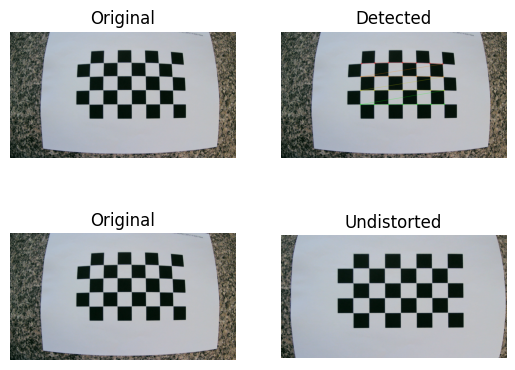

Loading Image data/WhiteBackground/calib_img_3.png
Yellow: 5 blob(s) found
Green: 3 blob(s) found
Red: 5 blob(s) found
Blue: 5 blob(s) found
No blobs found for color(s): Brown


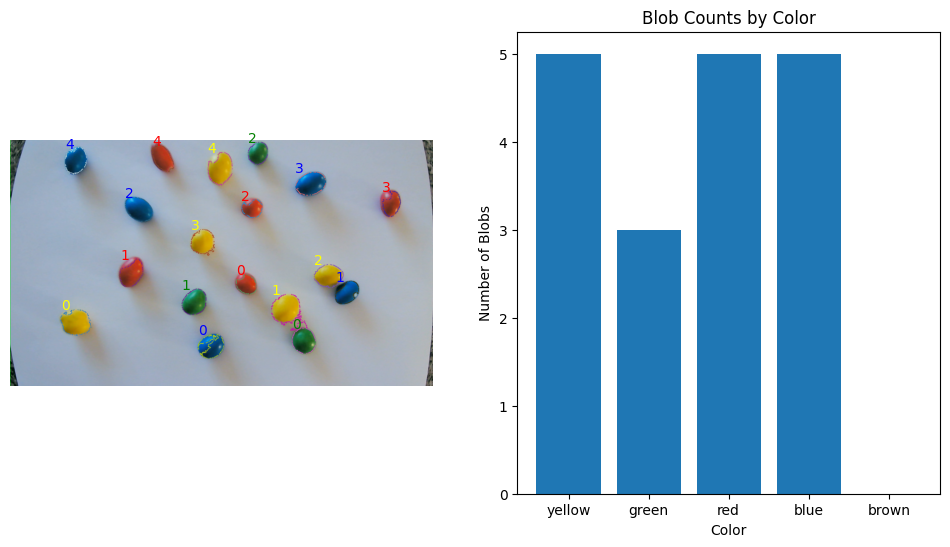

For color Yellow, the average size is 7443.000 in pix and the standard deviation is 1259.046 in pix
                                     4.706 in mm²                          0.796 in mm²
For color Green, the average size is 5665.667 in pix and the standard deviation is 829.499 in pix
                                     3.582 in mm²                          0.524 in mm²
For color Red, the average size is 4354.400 in pix and the standard deviation is 839.236 in pix
                                     2.753 in mm²                          0.531 in mm²
For color Blue, the average size is 5706.100 in pix and the standard deviation is 942.878 in pix
                                     3.608 in mm²                          0.596 in mm²


In [155]:
# White Background

import random
images = sorted(glob.glob(f'data/WhiteBackground/calib_img_3.png'))
path_ex ='data/WhiteBackground/extrinsic.png'
print(f'Loading Image {path_ex}')

extrinsic = cv.imread(path_ex)
outtype = 'all'

mtx, dist , mm2pix = calibration(extrinsic, outtype)

for fname in images:

    print(f"Loading Image {fname}")
    img = cv.imread(fname)
    unwarped = unwarp(img, mtx, dist)
    roi = white_background(unwarped, outtype)
    count_candies(roi, mm2pix)
    
     
    


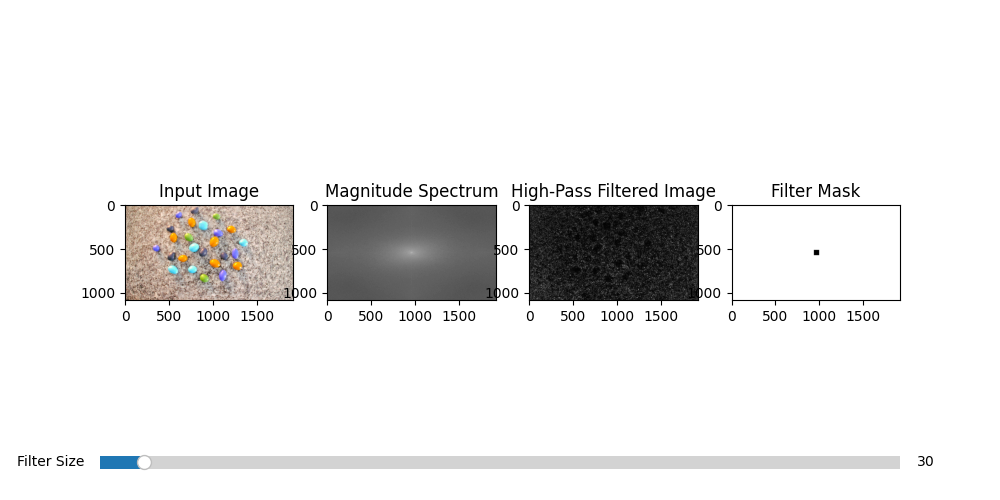

In [10]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider

%matplotlib widget

def frequency_filter(image):
    # Convert image to grayscale
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Fourier transform
    f = np.fft.fft2(img)

    # Shift origin to center
    fshift = np.fft.fftshift(f)

    # Magnitude spectrum
    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Create figure with subplots
    fig, axs = plt.subplots(1, 4, figsize=(10, 5))

    # Plot input image
    axs[0].imshow(image)
    axs[0].set_title('Input Image')

    # Plot magnitude spectrum
    axs[1].imshow(magnitude_spectrum, cmap='gray')
    axs[1].set_title('Magnitude Spectrum')

    # Plot high-pass filtered image
    img_filtered = apply_filter(fshift, img.shape, 30)
    axs[2].imshow(img_filtered, cmap='gray')
    axs[2].set_title('High-Pass Filtered Image')

    # Plot filter mask
    mask = create_mask(img.shape, 30)
    axs[3].imshow(mask, cmap='gray')
    axs[3].set_title('Filter Mask')

    # Add slider for filter size
    slider_ax = fig.add_axes([0.1, 0.05, 0.8, 0.05])
    slider = Slider(slider_ax, 'Filter Size', valmin=0, valmax=min(img.shape)//2, valinit=30)

    # Update plot when slider is changed
    def update(val):
        # Update filter size
        filter_size = int(slider.val)

        # Update high-pass filtered image and filter mask
        img_filtered = apply_filter(fshift, img.shape, filter_size)
        mask = create_mask(img.shape, filter_size)

        # Update plot
        axs[2].imshow(img_filtered, cmap='gray')
        axs[3].imshow(mask, cmap='gray')
        plt.draw()

    # Connect slider to update function
    slider.on_changed(update)

    # Show plot
    plt.show()

def apply_filter(fshift, shape, filter_size):
    # High pass filter
    rows, cols = shape
    crow, ccol = rows//2, cols//2
    mask = create_mask(shape, filter_size)

    # Apply mask
    fshift_filtered = fshift * mask

    # Shift origin back to corner
    f_filtered = np.fft.ifftshift(fshift_filtered)

    # Inverse Fourier transform
    img_filtered = np.fft.ifft2(f_filtered)
    img_filtered = np.abs(img_filtered)

    return img_filtered

def create_mask(shape, filter_size):
    rows, cols = shape
    crow, ccol = rows//2, cols//2
    mask = np.ones((rows, cols), np.uint8)
    mask[crow-filter_size:crow+filter_size, ccol-filter_size:ccol+filter_size] = 0
    return mask


img = cv2.imread('data/GreyBackground/calib_img_4.png')
frequency_filter(img)
